<a href="https://colab.research.google.com/github/sfeye/CS461-AI/blob/master/Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installs / Imports

To start we need to confirm that both Tensorflow, Keras and Pandas are installed.

In [ ]:
!pip install tensorflow
!pip install pandas
!pip install numpy
!pip install keras

Next we import these dependencies.

In [26]:
import tensorflow as tf
import pandas as pd
import numpy as np

## IO & pd.read

Now we use google.colab files.upload() to pull in the file and use pandas to read the csv.

In [28]:
from google.colab import files
# file = files.upload()

training_dataset = pd.read_csv("training_data.csv")
testing_dataset = pd.read_csv("testing_data.csv")

## Preprocessing

Now we transform each column. First we will start with Label Encoding.

In [29]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

training_dataset["Gender"] = label_encoder.fit_transform(training_dataset["Gender"].values)
testing_dataset["Gender"] = label_encoder.transform(testing_dataset["Gender"].values)

training_dataset["Age"] = label_encoder.fit_transform(training_dataset["Age"].values)
testing_dataset["Age"] = label_encoder.transform(testing_dataset["Age"].values)

training_dataset["Vehicle_Age"] = label_encoder.fit_transform(training_dataset["Vehicle_Age"].values)
testing_dataset["Vehicle_Age"] = label_encoder.transform(testing_dataset["Vehicle_Age"].values)

training_dataset["Policy_Sales_Channel"] = label_encoder.fit_transform(training_dataset["Policy_Sales_Channel"].values)
testing_dataset["Policy_Sales_Channel"] = label_encoder.transform(testing_dataset["Policy_Sales_Channel"].values)

Now we do the 1-Hot Encoding.

In [30]:
from sklearn.preprocessing import OneHotEncoder

features = ["Gender","Age","Region_Code","Vehicle_Age","Policy_Sales_Channel"]
training_one_hot = training_dataset[features].values
testing_one_hot = testing_dataset[features].values 

one_hot_encoder = OneHotEncoder(sparse=False)
training_one_hot = one_hot_encoder.fit_transform (training_one_hot)
testing_one_hot = one_hot_encoder.fit_transform (testing_one_hot)

Gender: 2
Age: 66
Region_Code: 53
Vehicle_Age: 3
Policy_Sales_Channel: 155


We still need to standardize some of the columns.

In [22]:
from sklearn.preprocessing import StandardScaler

training_dataset[['Annual_Premium', 'Vintage']] = pd.DataFrame(StandardScaler().fit_transform(training_dataset[['Annual_Premium', 'Vintage']]))
testing_dataset[['Annual_Premium', 'Vintage']] = pd.DataFrame(StandardScaler().fit_transform(testing_dataset[['Annual_Premium', 'Vintage']]))

Then we can encode those responses some more to make it easier to classify Regions and Policy Sales Channels.



In [31]:
def get_response_coded_feature_dict(alpha, feature, df):
    value_count = df[feature].value_counts()
    n = df[feature].nunique()
    feature_dict = dict()
    for i, denominator in value_count.items():
        vec = []        
        for k in range(0,2):
            cls_cnt = df.loc[(df['Response']==k) & (df[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha)/ (denominator + n*alpha))
        feature_dict[i]=vec
    return feature_dict

def get_response_coded_feature(alpha, feature, train_df,test_df):
    response_coded_feature_dict = get_response_coded_feature_dict(alpha, feature, train_df)
    train_value_count = train_df[feature].value_counts()
    n = train_df[feature].nunique()
    train_response_coded_feature = []
    test_response_coded_feature = []
    for index, row in train_df.iterrows():
        if row[feature] in dict(train_value_count).keys():
            train_response_coded_feature.append(response_coded_feature_dict[row[feature]])
        else:
            train_response_coded_feature.append([1/n,1/n])
    for index, row in test_df.iterrows():
        if row[feature] in dict(train_value_count).keys():
            test_response_coded_feature.append(response_coded_feature_dict[row[feature]])
        else:
            test_response_coded_feature.append([1/n,1/n])        
    return train_response_coded_feature,test_response_coded_feature



train_region_code_feature_responseCoding,test_region_code_feature_responseCoding = np.array(get_response_coded_feature(1, "Region_Code", training_dataset, testing_dataset))

train_Policy_Sales_Channel_feature_responseCoding,test_Policy_Sales_Channel_feature_responseCoding = np.array(get_response_coded_feature(1, "Policy_Sales_Channel", training_dataset, testing_dataset))

In [33]:
X = np.hstack((training_one_hot, train_region_code_feature_responseCoding,
               train_Policy_Sales_Channel_feature_responseCoding,
               training_dataset[["Age","Annual_Premium","Vintage"]]))
y = training_dataset["Response"].values

In [35]:
from sklearn.preprocessing import MinMaxScaler

minmaxscaler = MinMaxScaler()
X =minmaxscaler.fit_transform(X)

In [37]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X ,y ,test_size=0.3, random_state=42)

## Training

In [38]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [50]:
def find_best_threshold(threshould, fpr, tpr):   
  t = threshould[np.argmax(tpr*(1-fpr))]
  # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
  print("The maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
  return t
 
def predict_with_best_t(proba, threshould):
  predictions = []
  for i in proba:
    if (i >= threshould):
      predictions.append(1)
    else:
      predictions.append(0)
  return predictions

## Classification

For the classification I ended up going with the Naive Bays.

In [55]:
from sklearn.naive_bayes import MultinomialNB
import math
from sklearn.model_selection import GridSearchCV

grid_params ={'alpha':[10**x for x in range(-4,4)]}
alpha_log = [math.log(x,10) for x in grid_params["alpha"]]

MultinomialNB_model = GridSearchCV(MultinomialNB(),grid_params,
                     scoring = 'roc_auc', cv=10,n_jobs=-1, return_train_score=True)
MultinomialNB_model.fit(X_train, y_train)

results = pd.DataFrame.from_dict(MultinomialNB_model.cv_results_)
results = results.sort_values(['param_alpha'])

## Output

And finally print the results.

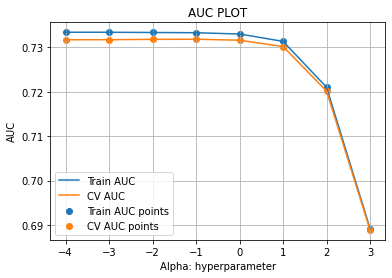

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)


In [54]:
import matplotlib.pyplot as plt

plt.plot(alpha_log, results["mean_train_score"], label='Train AUC')
plt.plot(alpha_log, results["mean_test_score"].values, label='Test AUC')

plt.scatter(alpha_log, results["mean_train_score"].values, label='Train AUC points')
plt.scatter(alpha_log, results["mean_test_score"].values, label='CV AUC points')

plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC PLOT")
plt.grid()
plt.show()
print(MultinomialNB_model.best_estimator_)

---
# Conclusion
---
### Results

As Displayed in the graph above our results were very close to the test data frame.
---
### Resonings
---
### Behind the scenes

Some of the main technologies used in this were Tensorflow, Pandas, and Numpy. The classification method I decided on was Naive Bays, mainly because of the simplicity of the records. FOr validations